In [225]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [226]:
# Train paths
kmnist_train_images = "./images/kmnist-train-imgs.npz"
kmnist_train_labels = "./images/kmnist-train-labels.npz"

# Test paths
kmnist_test_images = "./images/kmnist-test-imgs.npz"
kmnist_test_labels = "./images/kmnist-test-labels.npz"

In [227]:
# Initial look at the data
kmnist_train_images = np.load(kmnist_train_images)["arr_0"]
kmnist_train_labels = np.load(kmnist_train_labels)["arr_0"]

kmnist_test_images = np.load(kmnist_test_images)["arr_0"]
kmnist_test_labels = np.load(kmnist_test_labels)["arr_0"]

print("Data Overview")
print("---------------------------------")
print(f"train_images type: {type(kmnist_train_images)}")
print(f"train_images dtype: {kmnist_train_images.dtype}")
print(f"train_images shape: {kmnist_train_images.shape}")
print(f"train_imagesn ndim: {kmnist_train_images.ndim}")
print("---------------------------------")
print(f"train_labels type: {type(kmnist_train_labels)}")
print(f"train_labels dtype: {kmnist_train_labels.dtype}")
print(f"train_labels shape: {kmnist_train_labels.shape}")
print(f"train_labels ndim: {kmnist_train_labels.ndim}")
print("---------------------------------")
print(f"test_images type: {type(kmnist_test_images)}")
print(f"test_images dtype: {kmnist_test_images.dtype}")
print(f"test_images shape: {kmnist_test_images.shape}")
print(f"test_images ndim: {kmnist_test_images.ndim}")
print("---------------------------------")
print(f"test_labels type: {type(kmnist_test_labels)}")
print(f"test_labels dtype: {kmnist_test_labels.dtype}")
print(f"test_labels shape: {kmnist_test_labels.shape}")
print(f"test_labels ndim: {kmnist_test_labels.ndim}")

Data Overview
---------------------------------
train_images type: <class 'numpy.ndarray'>
train_images dtype: uint8
train_images shape: (60000, 28, 28)
train_imagesn ndim: 3
---------------------------------
train_labels type: <class 'numpy.ndarray'>
train_labels dtype: uint8
train_labels shape: (60000,)
train_labels ndim: 1
---------------------------------
test_images type: <class 'numpy.ndarray'>
test_images dtype: uint8
test_images shape: (10000, 28, 28)
test_images ndim: 3
---------------------------------
test_labels type: <class 'numpy.ndarray'>
test_labels dtype: uint8
test_labels shape: (10000,)
test_labels ndim: 1


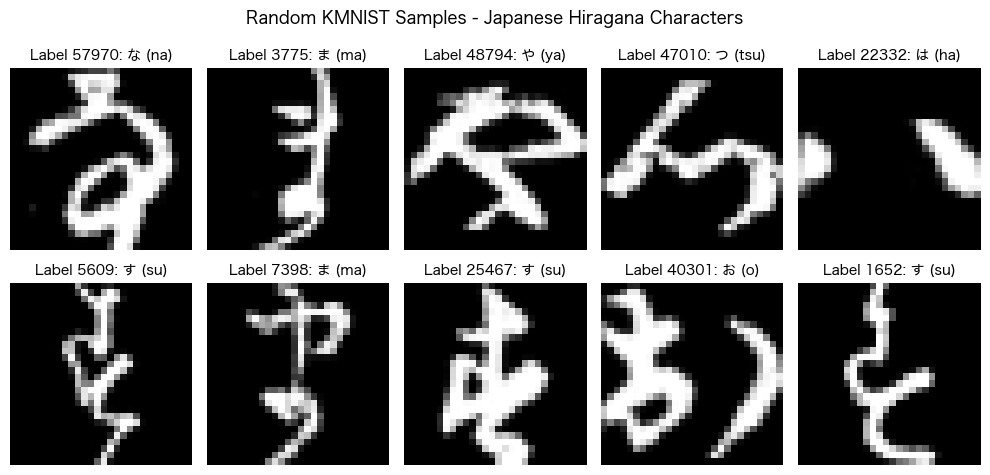

In [228]:
# Set font that supports Japanese characters since DejaVu Sans does not support it.
plt.rcParams["font.family"] = "Hiragino Sans"

kmnist_classes = {
    0: "お (o)",
    1: "き (ki)",
    2: "す (su)",
    3: "つ (tsu)",
    4: "な (na)",
    5: "は (ha)",
    6: "ま (ma)",
    7: "や (ya)",
    8: "れ (re)",
    9: "を (wo)"
}

# Plot some Hiragana Characters randomly.
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for _, ax in enumerate(axes.flat):
    rand_idx = random.randint(0, kmnist_train_images.shape[0] - 1)
    ax.imshow(kmnist_train_images[rand_idx], cmap="gray")
    label_index = y_train[rand_idx]
    ax.set_title(f"Label {rand_idx}: {kmnist_classes[label_index]}", fontsize=10)
    ax.axis("off")

plt.suptitle("Random KMNIST Samples - Japanese Hiragana Characters")
plt.tight_layout()
plt.show();

In [236]:
# Building the CNN

class CNN(nn.Module):
    """
    CNN (Convolutional Neural Network) for KMNIST Classification. This uses 3 convolution layers and 2 fully connected layers.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # 1 input channel (grayscale), 32 channels, 3x3 kernel size (feature), moving filter by 1 pixel at a time, then adding the padding for 28 x 28, 32 x 28 x 28 -> 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 64 channels, extracting more features, 14 x 14, 32 x 14 x 14 -> 64 x 7 x 7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 128 channels, extracting even more features, 7 x 7 -> 128 x 7 x 7
        self.bn1 = nn.BatchNorm2d(32) # Normalizes the inputs of each layer so it makes faster computations, 32 channels here
        self.bn2 = nn.BatchNorm2d(64) # Normalization, 64 channels here
        self.bn3 = nn.BatchNorm2d(128) # Normaliztion, 128 channels here
        self.pool = nn.MaxPool2d(2) # 2x2 pooling to extract the essential features
        self.dropout = nn.Dropout2d(0.25) # This drops 25% of the features so basically that the model can "learn" better

        self.fc1 = nn.Linear(128 * 3 * 3, 128) # Hyperparameter of 128 - fully connected layers
        self.fc2 = nn.Linear(128, 10) # 10 is the output - 10 different outputs for KMNIST

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [237]:
# Initializing the CNN
cnn = CNN()

In [238]:
# Image Transformation Pipeline for PyTorch. Transforms the data to tensors and we also will add some noise to the train dataset. Lastly, we will normalize the values.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random generic transformations to the dataset so it prevents overfitting and also the varities to make the model more robust. 10 degree rotation, moves image randomly up to 10% of the pixels, and random scaling of 90-110%.
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Changes the contrast and brightness by ±10%.
    transforms.Normalize((0.1918,), (0.3483,)) # Normalize the values - these are the values for KMNIST (mean and SD).
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1918,), (0.3483,))
])

In [239]:
# The KMNIST Dataset class. We created a custom Dataset class as images are labels are split for both test and training.
class KMNISTDataset(Dataset): # PyTorch Dataset is just a class that represents our dataset.
    def __init__(self, images, labels, transform):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        label = self.labels[index]

        return image, label

In [240]:
# Creating the Dataset
train_dataset = KMNISTDataset(kmnist_train_images, kmnist_train_labels, train_transforms)
test_dataset = KMNISTDataset(kmnist_test_images, kmnist_test_labels, test_transforms)

In [241]:
# Create a Training and Validating Class that trains and validates the model

class TrainVal:
    def __init__(self, model, train_data, test_data, num_epochs, batch_size, lr=0.001):
        # Initial Setup
        self.model = model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.num_epochs = num_epochs
        
        # Creating the DataLoaders
        self.train_loader = DataLoader(train_data, batch_size, shuffle=True) # DataLoaders help feed data in to our model in manageable "chunks". We want to shuffle our data for training, and our batch size is a hyperparameter - how many data samples to look at.
        self.test_loader = DataLoader(test_data, batch_size, shuffle=False) # shuffle = False in this case as this is a test dataset.

        # Setting Up Loss Function and Optimizer
        self.loss_fn = nn.CrossEntropyLoss() # Cross Entropy Loss - common for classification problems and basically compares model's output to ground truth - lower loss is better.
        self.optimizer = optim.Adam(self.model.parameters(), lr) # Function to update model's weight to up the performance/minimize loss. Learning Rate (of 0.001) is how much the "step" the optimizer takes to update the model's weights when learning the model.

    def fire(self):

        train_loss_list = []
        val_loss_list = []
        correct_list = []

        # Training
        for epoch in range(self.num_epochs):

            running_loss = 0

            for images, labels in self.train_loader:
            
                self.optimizer.zero_grad() # Erase accumulated gradients
                output = self.model(images) # Forward pass
                train_loss = self.loss_fn(output, labels) # Loss Function
                train_loss.backward() # Back propogation
                self.optimizer.step() # Update the weight here

                running_loss += train_loss.item()

            train_loss_list[epoch] = train_loss / len(labels)

            print(f"Epoch {epoch + 1}, Train Loss: {train_loss_list[epoch]}")

        # Validating
        self.model.eval()

        val_loss = 0
        num_correct = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                output = self.model(images)
                val_loss = self.loss_fn(output, labels).item()
                _, pred = torch.max(output.data, dim=1)
                num_correct += (pred == labels).sum().item()


        val_loss_list[epoch] = val_loss / len(labels)
        correct_list[epoch] = num_correct / len(labels)

        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss_list[epoch]}, Accuracy: {correct_list[epoch]}")

In [ ]:
num_epochs = 20

train_and_val = TrainVal(cnn, train_dataset, test_dataset, num_epochs, 32)

train_and_val.fire()